In [1]:
import numpy as np
import pandas as pd
import os

# 데이터 불러오기

In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path, encoding='euckr')

In [3]:
data_path = 'data'
data = [load_data(os.path.join(data_path, filename)) for filename in os.listdir(data_path)]
data[0]

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
0,2023/05/09,555000,-3000,-0.54,558000,567000,550000,101803,56752966000,129870000000000,234000000
1,2023/05/08,558000,-6000,-1.06,565000,572000,558000,202092,114162505000,130572000000000,234000000
2,2023/05/04,564000,-3000,-0.53,563000,571000,560000,244181,137592002000,131976000000000,234000000
3,2023/05/03,567000,-24000,-4.06,587000,587000,566000,243943,139845914000,132678000000000,234000000
4,2023/05/02,591000,10000,1.72,580000,592000,579000,273527,160973712000,138294000000000,234000000
...,...,...,...,...,...,...,...,...,...,...,...
244,2022/05/13,400500,12500,3.22,390500,401500,390500,228636,90861595500,93717000000000,234000000
245,2022/05/12,388000,-3500,-0.89,390000,395500,386000,251570,98271466500,90792000000000,234000000
246,2022/05/11,391500,-2000,-0.51,394000,398000,391500,239355,94448041000,91611000000000,234000000
247,2022/05/10,393500,-500,-0.13,387500,398500,382000,407928,159437583000,92079000000000,234000000


# 종목별 기대수익률 및 공분산 행렬 계산

In [4]:
changes = pd.DataFrame([d['등락률'] for d in data]).T
changes.columns = ['LGES', 'POSCO', 'Kia', 'Samsung Bio']
changes

,LGES,POSCO,Kia,Samsung Bio
0,-0.54,-0.41,-0.80,0.00
1,-1.06,-3.03,1.40,-1.13
2,-0.53,-0.26,-0.69,2.84
3,-4.06,-0.52,-0.46,1.04
4,1.72,1.33,2.84,-1.79
...,...,...,...,...
244,3.22,2.75,0.00,-0.38
245,-0.89,-0.55,0.23,-0.63
246,-0.51,-0.54,2.38,-0.63
247,-0.13,-1.78,1.82,0.00


In [5]:
# 전체 기간 환산
days = len(changes)

In [6]:
# 등락률은 % 단위
returns = changes.mean()
annual_returns = returns * days
annual_returns

LGES           38.40
POSCO          31.08
Kia             7.10
Samsung Bio     1.76
dtype: float64

In [7]:
variance = changes.var()
annual_variance = variance * days
annual_variance

LGES           1203.360445
POSCO          1304.347761
Kia             827.358877
Samsung Bio     495.339877
dtype: float64

In [8]:
cov_matrix = changes.cov()
annual_cov = cov_matrix * days
annual_cov

,LGES,POSCO,Kia,Samsung Bio
LGES,1203.360445,351.934431,267.815725,153.714807
POSCO,351.934431,1304.347761,330.020567,82.550346
Kia,267.815725,330.020567,827.358877,97.941254
Samsung Bio,153.714807,82.550346,97.941254,495.339877


# 초과수익률 기준: 연 5%

In [9]:
# 등락률의 단위가 %이므로 초과수익률도 % 단위로 선언
C = 5

# 공분산행렬의 역행렬 계산

In [10]:
annual_cov_inv = np.linalg.inv(annual_cov)
annual_cov_inv

array([[ 9.62472497e-04, -1.92807176e-04, -2.07958705e-04,
        -2.25425499e-04],
       [-1.92807176e-04,  8.94203121e-04, -2.90513791e-04,
        -3.17482494e-05],
       [-2.07958705e-04, -2.90513791e-04,  1.41153099e-03,
        -1.66146059e-04],
       [-2.25425499e-04, -3.17482494e-05, -1.66146059e-04,
         2.12691259e-03]])

# 최적 투자 비율 계산

In [11]:
z = np.matmul(annual_cov_inv, annual_returns-C)
z

array([ 0.02741184,  0.01637384, -0.01101989, -0.01559731])

In [12]:
sum_z = z.sum()
w = [zi/sum_z for zi in z]
w

[1.5966375768835812,
 0.9537155245353315,
 -0.6418677726144588,
 -0.9084853288044541]

# 효율적 포트폴리오의 투자 비율
* LG에너지솔루션: 159%
* POSCO홀딩스: 95%
* 기아: -64%
* 삼성바이오로직스: -90%

# 투자 비율별 기대수익률, 위험

In [13]:
weight_returns = []
weight_risk = []

In [14]:
def return_risk(weight: np.array):
    cur_returns = np.dot(weight, annual_returns)
    cur_risk = np.sqrt(np.dot(weight.T, np.dot(annual_cov, weight)))
    return cur_returns, cur_risk

In [15]:
# random weights
import random
stock_num = len(data)
for _ in range(100_000):
    random_numbers = np.random.random(stock_num)
    weight = random_numbers / random_numbers.sum()
    w_return, w_risk = return_risk(weight)
    weight_returns.append(w_return)
    weight_risk.append(w_risk)

In [16]:
weight_returns = np.array(weight_returns)
weight_risk = np.array(weight_risk)

In [17]:
best_return, best_risk = return_risk(np.array(w))
print(best_return, best_risk)

84.79616609062914 68.17499688668866


# 효율적 결합선 그리기

In [18]:
import matplotlib.pyplot as plt

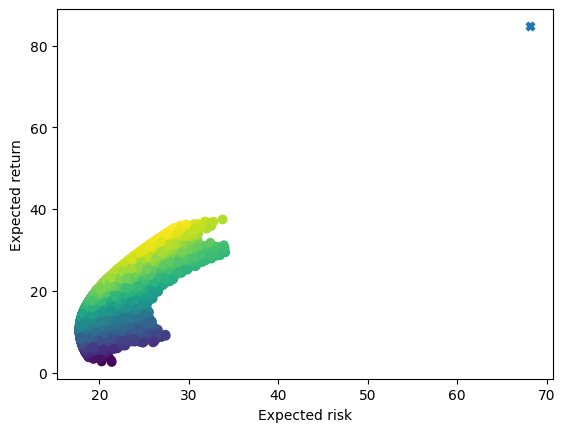

In [19]:
plt.scatter(x=weight_risk, y=weight_returns, c=weight_returns/weight_risk)
plt.scatter(x=best_risk, y=best_return, marker='X')

plt.xlabel('Expected risk')
plt.ylabel('Expected return')
plt.show()